# Performance Evaluation on Real Captured Event Data

- **Case 1**: Rigid-body rotation scenario, captured using our self-developed EBIV setup.  
- **Case 2**: Water flow field scenario, adapted from the EBIV reference study.  

### Experimental Settings
- A temporal window of **10 ms** was extracted for event accumulation.  
- A spatial window of **51 × 51 pixels** was employed.  
- The step size was set to **40 pixels**.  

In [1]:
import torch
import numpy as np

from generator.loader import EventManager


from utils.spliter import filter_events_by_time_polarity

from kernels.correlation import estimateCC
from kernels.opticalflow import estimateOF
from kernels.cmax import estimateCMAX
from kernels.pcm import estimatePCM,objective2d_origin,objective2d_smooth
from kernels.pcm import estimatePCMB, estimatePCMSA
from framework import PIVFramework

# from utils.spliter import split_events_voxelized
from utils.visualizer import plot_flow_field
from utils.visualizer import plot_event_time2d

from addict import Dict

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

def default_config():
    cfg = Dict()
    cfg.start = (0, 0)
    cfg.H = 720-1
    cfg.W = 1280-1
    cfg.step = 40
    cfg.min_events = 100
    cfg.max_events = 2000

    cfg.t_min = 0.0
    cfg.t_max = 1000
    cfg.x_span = 51
    cfg.y_span = 51
    cfg.method_args = Dict(H=cfg.x_span, W=cfg.y_span)
    return cfg

cuda


In [2]:
def testPIVFramework(evts, cfg, case='rot', ut=None, vt=None, v_min=None, v_max=None, scale=None,figsize=(6,3)):
    from kernels.correlation import estimateCC
    from kernels.opticalflow import estimateOF
    
    from kernels.cmax import estimateCMAX
    from kernels.pcm import estimatePCMB, estimatePCMSA

    from utils.visualizer import plot_flow_field

    if ut is not None and vt is not None:
        cx = torch.arange(0, cfg.H+1, cfg.step)+cfg.start[0]
        cy = torch.arange(0, cfg.W+1, cfg.step)+cfg.start[1]
        xx, yy = torch.meshgrid(cx,cy,indexing='ij')
        u_s = u_t1[xx,yy]
        v_s = v_t1[xx,yy]
        output_file = f"output/Fig16_{case}_truth.pdf"
        plot_flow_field(u_s[1:-1,1:-1], v_s[1:-1,1:-1], output_file=output_file, quiver_step=1, slFlag=False, v_min=v_min, v_max=v_max, scale=scale, figsize=figsize)


    rmses, aees = [], []
    for method in [estimateCC, estimateOF, estimateCMAX, estimatePCMB, estimatePCMSA]:
        cfg.method = method
        framework = PIVFramework(cfg)
        u, v, centers = framework.compute(evts)
        output_file = f"output/Fig16_{case}_{method.__name__}.pdf"
        plot_flow_field(u[1:-1,1:-1], v[1:-1,1:-1], output_file=output_file, quiver_step=1, slFlag=False, v_min=v_min, v_max=v_max, scale=scale, figsize=figsize)

        if ut is not None:
            epe = np.sqrt((u-u_s)**2+(v-v_s)**2)
            epe = np.clip(epe, a_min=0,a_max=1.0) # bound the outliers 
            rmse = np.sqrt(np.nanmean(np.square(epe[1:-1,1:-1])))
            aee = np.nanmean(epe[1:-1,1:-1])
    
            rmses.append(rmse)
            aees.append(aee)
    print("RMSE:", np.round(rmses, 3))
    print("AEE :", np.round(aees, 3))

## **Case 1**: Rigid-body rotation scenario, captured using our self-developed EBIV setup.  

Figure saved to output/Fig15_a.pdf


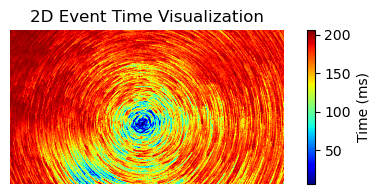

Figure saved to output/Fig16_rot1_truth.pdf


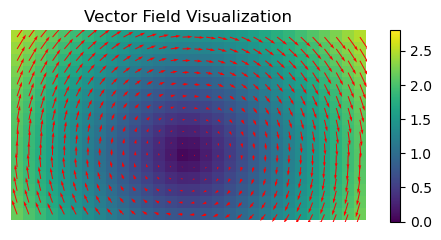

Start splitting event blocks...
Start velocity estimation per block... cuda:0


Figure saved to output/Fig16_rot1_estimateCC.pdf


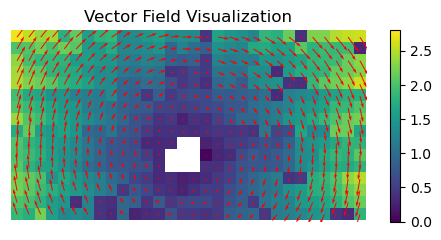

Start splitting event blocks...
Start velocity estimation per block... cuda:0


Figure saved to output/Fig16_rot1_estimateOF.pdf


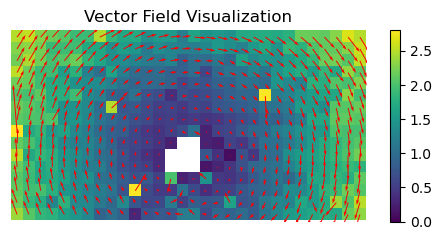

Start splitting event blocks...
Start velocity estimation per block... cuda:0


Figure saved to output/Fig16_rot1_estimateCMAX.pdf


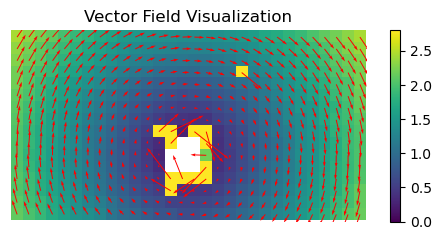

Start splitting event blocks...
Start velocity estimation per block... cuda:0


Figure saved to output/Fig16_rot1_estimatePCMB.pdf


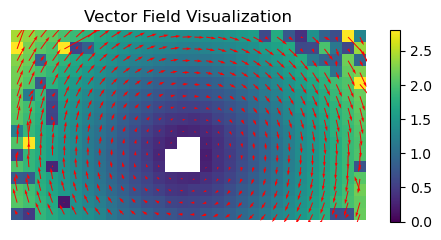

Start splitting event blocks...
Start velocity estimation per block... cuda:0


Figure saved to output/Fig16_rot1_estimatePCMSA.pdf


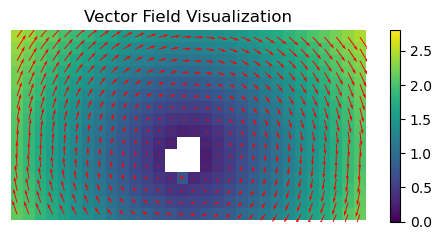

RMSE: [0.258 0.24  0.176 0.29  0.041]
AEE : [0.179 0.165 0.061 0.11  0.029]


In [3]:
# Read the real rotation
case = Dict(source_type="evk5", path="./data/rotation8.23.hdf5")

event_loader = EventManager(**case)
evts, (u,v) = event_loader.load()
evts1 = torch.tensor(evts)

data = np.load("./data/rotation8.23_truth.npz") # estimated by ECC registration for two frames (voxel grids)
u_t1 = data["u"]
v_t1 = data["v"]

plot_event_time2d(evts1, output_file="output/Fig15_a.pdf")
evts1 = filter_events_by_time_polarity(evts1, t_min=100, t_max=110, polarity=1)

cfg  = default_config()
testPIVFramework(evts1.to(device), cfg, case='rot1', ut=u_t1, vt=v_t1, v_min=0.0, v_max=2.8, scale=50, figsize=(5,2.3))

## **Case 2**: Water flow field scenario, adapted from the EBIV reference study. 

Figure saved to output/Fig15_b.pdf


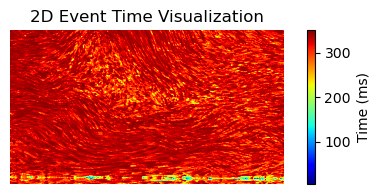

Start splitting event blocks...
Start velocity estimation per block... cuda:0


Figure saved to output/Fig16_water_estimateCC.pdf


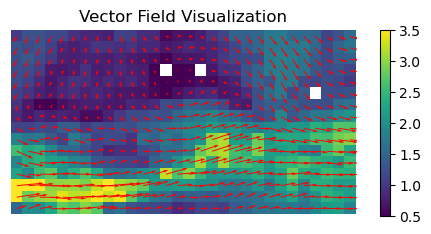

Start splitting event blocks...
Start velocity estimation per block... cuda:0


Figure saved to output/Fig16_water_estimateOF.pdf


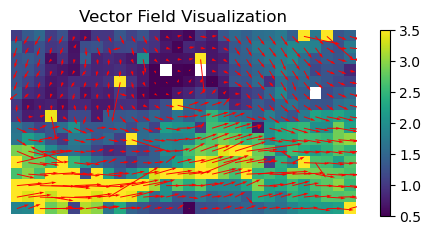

Start splitting event blocks...
Start velocity estimation per block... cuda:0


Figure saved to output/Fig16_water_estimateCMAX.pdf


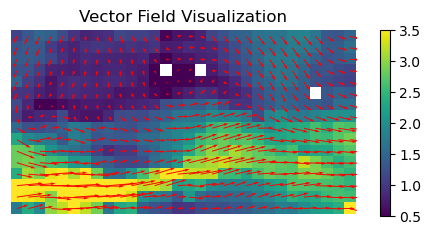

Start splitting event blocks...
Start velocity estimation per block... cuda:0


Figure saved to output/Fig16_water_estimatePCMB.pdf


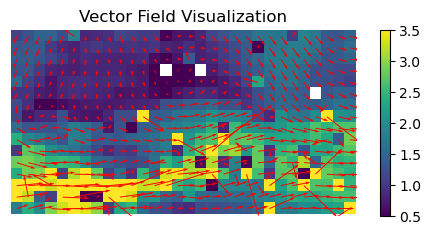

Start splitting event blocks...
Start velocity estimation per block... cuda:0


Figure saved to output/Fig16_water_estimatePCMSA.pdf


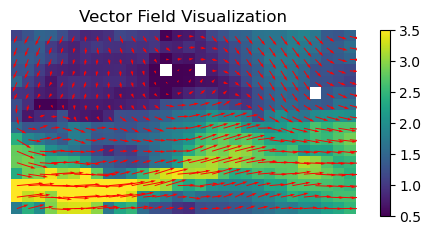

RMSE: []
AEE : []


In [4]:
# Read the real water flow 
case = Dict(source_type="real", path="./data/ebiv_wallflow4_dense_3.h5")
event_loader = EventManager(**case)
evts, (u,v) = event_loader.load()
evts2 = torch.tensor(evts)

plot_event_time2d(evts2, output_file="output/Fig15_b.pdf")
evts2 = filter_events_by_time_polarity(evts2, t_min=100, t_max=110, polarity=1)

testPIVFramework(evts2.to(device), cfg, case='water', v_min=0.5, v_max=3.5, scale=50,figsize=(5,2.3))